In [190]:
import tensorflow as tf

import numpy as np

Loading and preparing the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). Converting the samples from integers to floating-point numbers:

In [191]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

Building the `tf.keras.Sequential` model by stacking layers.

In [192]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

In [193]:
predictions = model(x_train[:1]).numpy()
predictions

array([[-0.32124674,  0.30143908,  0.04246761, -0.42036968, -0.34151337,
        -0.40173784, -0.06959916, -0.4201354 , -0.25619662,  0.6053867 ]],
      dtype=float32)

In [194]:
tf.nn.softmax(predictions).numpy()

array([[0.07754335, 0.14453518, 0.11155876, 0.07022569, 0.07598763,
        0.07154639, 0.09973181, 0.07024214, 0.08275524, 0.1958738 ]],
      dtype=float32)

In [195]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [196]:
loss_fn(y_train[:1], predictions).numpy()

2.6374092

In [197]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [198]:
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2983 - accuracy: 0.9128
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1392 - accuracy: 0.9585
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1052 - accuracy: 0.9679
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0862 - accuracy: 0.9732
Epoch 5/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0756 - accuracy: 0.9764


In [199]:
model.evaluate(x_test,  y_test, verbose=2)

313/313 - 0s - loss: 0.0753 - accuracy: 0.9761


[0.07533738017082214, 0.9761000275611877]

In [200]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

### Generic function to get the signed gradients

In [201]:
def adversarial_pattern(image, label):
  image = tf.convert_to_tensor(image, dtype=tf.float32)

  with tf.GradientTape() as tape:
      tape.watch(image)
      prediction = model(image)
      loss = loss_fn(label, prediction)
  
  gradient = tape.gradient(loss, image)
  
  signed_grad = tf.sign(gradient)
  
  return signed_grad

In [202]:
labels = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

### 1. FGSM Attacks (Untargeted - Output a Misclassification)

### Sample test attack on a single image

In [203]:
image = x_train[0]

In [204]:
image_label = y_train[0]
print(image_label)

5


In [205]:
perturbations = adversarial_pattern(image.reshape((1, 28, 28)), image_label).numpy()


In [206]:
import matplotlib.pyplot as plt

adversarial = tf.clip_by_value(image + perturbations * 0.1,-1,1)
print(adversarial.shape)


(1, 28, 28)


In [207]:
print("Actual Output")
print(labels[model.predict(image.reshape((1, 28, 28))).argmax()])
print("Prediction after perturbation")
print(labels[model.predict(adversarial).argmax()])

Actual Output
five
Prediction after perturbation
three


In [208]:
epsilons = [1, 5, 10 , 20, 30, 40, 50]

for i, eps in enumerate(epsilons):
  correct = 0
  incorrect = 0
  correctly_misclassified = 0
  original_correct = 0

  image = x_test
  image_label = y_test
  perturbations = adversarial_pattern(image, image_label).numpy()
  adv_x = image + (eps/255)*perturbations
  adv_x = tf.clip_by_value(adv_x, 0, 1).numpy()
  prediction = model.predict(image)
  prediction_adv = model.predict(adv_x)
  for predicted_label, predicted_label_adv, actual_label in zip(prediction, prediction_adv, y_test):
    # success rate => out of the correctly predicted labels in the original model, how many are now correctly misclassified
    if actual_label == predicted_label.argmax():
      original_correct += 1
      if actual_label != predicted_label_adv.argmax():
        correctly_misclassified += 1
    # accuracy
    if predicted_label_adv.argmax() == actual_label:
      correct+=1
    else:
      incorrect+=1
  accuracy = (correct/(correct+incorrect))*100
  print("Accuracy for Epsilon {:.2f} is {:.2f}%".format(eps, accuracy))
  print("Success rate of the attack for Epsilon {:.2f} is {:.2f}%".format(eps, (correctly_misclassified*100/original_correct) ))

Accuracy for Epsilon 1.00 is 97.06%
Success rate of the attack for Epsilon 1.00 is 0.56%
Accuracy for Epsilon 5.00 is 92.92%
Success rate of the attack for Epsilon 5.00 is 4.80%
Accuracy for Epsilon 10.00 is 81.13%
Success rate of the attack for Epsilon 10.00 is 16.88%
Accuracy for Epsilon 20.00 is 39.27%
Success rate of the attack for Epsilon 20.00 is 59.77%
Accuracy for Epsilon 30.00 is 14.69%
Success rate of the attack for Epsilon 30.00 is 84.95%
Accuracy for Epsilon 40.00 is 5.76%
Success rate of the attack for Epsilon 40.00 is 94.10%
Accuracy for Epsilon 50.00 is 2.08%
Success rate of the attack for Epsilon 50.00 is 97.87%


### 2. FGSM with Targeted variable

In [209]:
image = x_train[10]

In [210]:
image_label = y_train[10]
print(image_label)

3


### Sample test prediction with a label => (label + 1)%10

In [211]:
perturbations = adversarial_pattern(image.reshape((1, 28, 28)), (image_label+1)%10).numpy()
adversarial = image - perturbations * 1
print("Actual Output")
print(labels[model.predict(image.reshape((1, 28, 28))).argmax()])
print("Prediction after perturbation")
print(labels[model.predict(adversarial).argmax()])

Actual Output
three
Prediction after perturbation
four


(1, 28, 28)


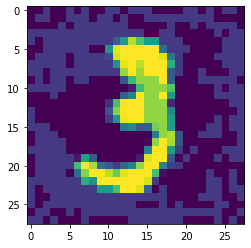

In [212]:
import matplotlib.pyplot as plt

adversarial = image + perturbations * 0.1
print(adversarial.shape)


plt.imshow(adversarial.reshape((28, 28)))

In [213]:
epsilons = [1, 5, 10 , 20, 30, 40, 50]

for i, eps in enumerate(epsilons):
  correct = 0
  incorrect = 0
  original_correct = 0
  correctly_misclassified = 0

  image = x_test
  image_label = (y_test+1)%10 

  perturbations = adversarial_pattern(image, image_label).numpy()
  adv_x = image - (eps/255)*perturbations
  adv_x = tf.clip_by_value(adv_x, 0, 1).numpy()
  prediction = model.predict(image)
  prediction_adv = model.predict(adv_x)
  for predicted_label, predicted_label_adv, actual_label in zip(prediction, prediction_adv, y_test):
    # success rate
    if actual_label == predicted_label.argmax():
      original_correct += 1
      if (predicted_label.argmax() + 1) % 10 == predicted_label_adv.argmax():
        correctly_misclassified+=1
    # accuracy after the attack
    if predicted_label_adv.argmax() == actual_label:
      correct+=1
    else:
      incorrect+=1
  accuracy = (correct/(correct+incorrect))*100
  print("Accuracy for Epsilon {:.2f} is {:.2f}%".format(eps, accuracy))
  print("Success rate of the attack for Epsilon {:.2f} is {:.2f}%".format(eps, (correctly_misclassified*100/original_correct) ))


Accuracy for Epsilon 1.00 is 97.53%
Success rate of the attack for Epsilon 1.00 is 0.03%
Accuracy for Epsilon 5.00 is 96.49%
Success rate of the attack for Epsilon 5.00 is 0.48%
Accuracy for Epsilon 10.00 is 91.58%
Success rate of the attack for Epsilon 10.00 is 2.39%
Accuracy for Epsilon 20.00 is 58.43%
Success rate of the attack for Epsilon 20.00 is 21.38%
Accuracy for Epsilon 30.00 is 29.74%
Success rate of the attack for Epsilon 30.00 is 39.90%
Accuracy for Epsilon 40.00 is 14.48%
Success rate of the attack for Epsilon 40.00 is 52.26%
Accuracy for Epsilon 50.00 is 6.50%
Success rate of the attack for Epsilon 50.00 is 59.76%


### 3. Defense Strategies Untargeted FGSM and Adversarial Retraining

#### Creating new data set with perturbed images

In [214]:
eps_defense = 10/255
x_train_perturbed = []
y_train_perturbed = []

perturbations = adversarial_pattern(x_train, y_train).numpy()
x_train_perturbed = x_train + eps_defense*perturbations
x_train_perturbed = tf.clip_by_value(x_train_perturbed, 0, 1).numpy()

y_train_perturbed = np.asarray(y_train)

In [215]:

print(x_train_perturbed.shape)
print(y_train_perturbed.shape)

(60000, 28, 28)
(60000,)


### Appending it to the original training data set







































In [216]:
x_train = np.append(x_train, x_train_perturbed, axis = 0)
y_train = np.append(y_train, y_train_perturbed, axis = 0)

In [217]:
print(x_train.shape)
print(y_train.shape)

(120000, 28, 28)
(120000,)


### Performing Retrain and evaluating on the original clean test data set

In [218]:
new_model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])
new_model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])
new_model.fit(x_train, y_train, epochs=5)

Epoch 1/5
3750/3750 [==============================] - 7s 2ms/step - loss: 0.2026 - accuracy: 0.9418
Epoch 2/5
3750/3750 [==============================] - 6s 2ms/step - loss: 0.0806 - accuracy: 0.9759
Epoch 3/5
3750/3750 [==============================] - 6s 2ms/step - loss: 0.0580 - accuracy: 0.9818
Epoch 4/5
3750/3750 [==============================] - 6s 2ms/step - loss: 0.0464 - accuracy: 0.9850
Epoch 5/5
3750/3750 [==============================] - 6s 2ms/step - loss: 0.0396 - accuracy: 0.9872


In [219]:
print("Reporting classification accuracy of the adversarially retrained DNN on the original test dataset", new_model.evaluate(x_test, y_test, verbose=2))


313/313 - 0s - loss: 0.0745 - accuracy: 0.9782
Reporting classification accuracy of the adversarially retrained DNN on the original test dataset [0.07445166260004044, 0.9782000184059143]


### Adversarial untargeted attack on the retrained data set using the new model

In [220]:
epsilons = [1, 5, 10, 20, 30, 40, 50]

for i, eps in enumerate(epsilons):
  correct = 0
  incorrect = 0
  original_correct = 0
  correctly_misclassified = 0

  image = x_test
  image_label = y_test
  perturbations = adversarial_pattern(image, image_label).numpy()
  adv_x = image + (eps/255)*perturbations
  adv_x = tf.clip_by_value(adv_x, 0, 1).numpy()
  prediction = new_model.predict(image)
  prediction_adv = new_model.predict(adv_x)
  for predicted_label, predicted_label_adv, actual_label in zip(prediction, prediction_adv, y_test):
    # success rate => out of the correctly predicted labels in the original model, how many are now correctly misclassified
    if actual_label == predicted_label.argmax():
      original_correct += 1
      if actual_label != predicted_label_adv.argmax():
        correctly_misclassified += 1
    # accuracy
    if predicted_label_adv.argmax() == actual_label:
      correct+=1
    else:
      incorrect+=1
  accuracy = (correct/(correct+incorrect))*100
  print("Accuracy for Epsilon {:.2f} is {:.2f}%".format(eps, accuracy))
  print("Success rate of the attack for Epsilon {:.2f} is {:.2f}%".format(eps, (correctly_misclassified*100/original_correct) ))

Accuracy for Epsilon 1.00 is 98.19%
Success rate of the attack for Epsilon 1.00 is 0.00%
Accuracy for Epsilon 5.00 is 99.14%
Success rate of the attack for Epsilon 5.00 is 0.00%
Accuracy for Epsilon 10.00 is 99.56%
Success rate of the attack for Epsilon 10.00 is 0.00%
Accuracy for Epsilon 20.00 is 99.92%
Success rate of the attack for Epsilon 20.00 is 0.01%
Accuracy for Epsilon 30.00 is 99.79%
Success rate of the attack for Epsilon 30.00 is 0.09%
Accuracy for Epsilon 40.00 is 99.51%
Success rate of the attack for Epsilon 40.00 is 0.34%
Accuracy for Epsilon 50.00 is 98.92%
Success rate of the attack for Epsilon 50.00 is 0.91%


#### The adversarially retrained DNN is robust against adversarial atacks as we can see that from the success rate of the attacks.